In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

In [76]:
# Load and merge all E-commerce dataset tables
def load_and_merge_data():
    """
    Load and merge all E-commerce dataset tables
    """
    # Load data
    customers = pd.read_csv('olist_customers_dataset.csv')
    orders = pd.read_csv('olist_orders_dataset.csv')
    order_items = pd.read_csv('olist_order_items_dataset.csv')
    products = pd.read_csv('olist_products_dataset.csv')
    payments = pd.read_csv('olist_order_payments_dataset.csv')
    
    # Merge data
    data = order_items.merge(orders, on='order_id', how='left')
    data = data.merge(customers, on='customer_id', how='left')
    data = data.merge(products, on='product_id', how='left')
    data = data.merge(payments, on='order_id', how='left')
    
    return data

In [77]:
print("Loading and merging data result")
data = load_and_merge_data()
print(f"data dimensions:{data.shape}")


Loading and merging data result
data dimensions:(117604, 30)


## Step 1: Removing Duplicate Data

In [78]:
print(f"Number of duplicate rows before removal: {data.duplicated().sum()}")

if data.duplicated().sum() > 0:
    print("Duplicate data detected, Removing")
    data = data.drop_duplicates()
    print(f"Number of rows after removing duplicates: {len(data)}")
else:
    print("No duplicate data found")


Number of duplicate rows before removal: 0
No duplicate data found


## Step 2: Handling Missing Values

In [89]:
# Check for missing values
missing_data = data.isnull().sum()
missing_percent = (data.isnull().sum() / len(data)) * 100

missing_info = pd.DataFrame({
    'Column': data.columns,
    'Missing_Count': missing_data,
    'Missing_Percent': missing_percent
}).sort_values('Missing_Percent', ascending=False)



In [80]:
print("Missing values percentage per column:")
print(missing_info[missing_info['Missing_Count'] > 0])

# Split columns based on missing values percentage
high_missing = missing_info[missing_info['Missing_Percent'] > 30]['Column'].tolist()
low_missing = missing_info[(missing_info['Missing_Percent'] <= 30) & 
                          (missing_info['Missing_Percent'] > 0)]['Column'].tolist()

# Handle columns with high missing values (>30%)
if high_missing:
    print(f"Removing columns with high missing values: {high_missing}")
    data = data.drop(columns=high_missing)
    print("Columns removed successfully")

# Handle columns with low missing values (<=30%)
for column in low_missing:
    print(f"Processing column: {column}")
    print(f"Missing values percentage: {missing_info[missing_info['Column'] == column]['Missing_Percent'].values[0]:.2f}%")
    
    # Determine column type for appropriate handling
    if data[column].dtype in ['object', 'category']:
        # For text/categorical data
        most_frequent = data[column].mode()[0] if not data[column].mode().empty else "Unknown"
        data[column] = data[column].fillna(most_frequent)
        print(f"Replaced missing values with most frequent: {most_frequent}")
    else:
        # For numerical data
        if column in ['price', 'freight_value', 'payment_value']:
            # Use median for financial data (less affected by outliers)
            median_val = data[column].median()
            data[column] = data[column].fillna(median_val)
            print(f"Replaced missing values with median: {median_val:.2f}")
        else:
            # Use mean for other numerical data
            mean_val = data[column].mean()
            data[column] = data[column].fillna(mean_val)
            print(f"Replaced missing values with mean: {mean_val:.2f}")



Missing values percentage per column:
                                                      Column  Missing_Count  \
order_delivered_customer_date  order_delivered_customer_date           2567   
product_photos_qty                        product_photos_qty           1698   
product_category_name                  product_category_name           1698   
product_name_lenght                      product_name_lenght           1698   
product_description_lenght        product_description_lenght           1698   
order_delivered_carrier_date    order_delivered_carrier_date           1245   
product_weight_g                            product_weight_g             20   
product_length_cm                          product_length_cm             20   
product_height_cm                          product_height_cm             20   
product_width_cm                            product_width_cm             20   
order_approved_at                          order_approved_at             15   
payment_instal

In [81]:
# Verify no missing values remain after processing
remaining_missing = data.isnull().sum().sum()
print(f"Total missing values after processing: {remaining_missing}")

Total missing values after processing: 0


## Step 3: Handling Outliers

In [82]:
# Identify numerical columns for outlier detection
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numerical columns for outlier check: {numeric_columns}")

# Detect outliers using IQR method
def detect_outliers_iqr(column):
    """Detect outliers using IQR method"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

for column in numeric_columns:
    if column in data.columns:
        print(f"Checking outliers in column: {column}")
        
        # Basic statistics
        print(f"Statistics: Min={data[column].min():.2f}, Max={data[column].max():.2f}, Mean={data[column].mean():.2f}")
        
        # Detect outliers
        outliers, lower_bound, upper_bound = detect_outliers_iqr(column)
        outlier_count = len(outliers)
        
        print(f"Number of potential outliers: {outlier_count}")
        print(f"Bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")
        
        # Handle outliers based on column nature
        if outlier_count > 0:
            if column in ['price', 'freight_value', 'payment_value']:
                # For financial data: cap outliers instead of deleting
                print(f"Outliers detected in {column} - applying caps")
                data[column] = np.where(data[column] > upper_bound, upper_bound, 
                                      np.where(data[column] < lower_bound, lower_bound, data[column]))
                print(f"Outliers capped within bounds")
            else:
                # For other data: delete outliers if few
                if outlier_count < len(data) * 0.05:  # Less than 5%
                    print(f"Removing {outlier_count} outliers")
                    data = data[~data.index.isin(outliers.index)]
                else:
                    print(f"Keeping outliers (high percentage: {outlier_count/len(data)*100:.2f}%)")



Numerical columns for outlier check: ['order_item_id', 'price', 'freight_value', 'customer_zip_code_prefix', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'payment_sequential', 'payment_installments', 'payment_value']
Checking outliers in column: order_item_id
Statistics: Min=1.00, Max=21.00, Mean=1.20
Number of potential outliers: 14547
Bounds: [1.00, 1.00]
Keeping outliers (high percentage: 12.37%)
Checking outliers in column: price
Statistics: Min=0.85, Max=6735.00, Mean=120.82
Number of potential outliers: 8844
Bounds: [-102.60, 277.40]
Outliers detected in price - applying caps
Outliers capped within bounds
Checking outliers in column: freight_value
Statistics: Min=0.00, Max=409.68, Mean=20.05
Number of potential outliers: 12683
Bounds: [0.91, 33.36]
Outliers detected in freight_value - applying caps
Outliers capped within bounds
Checking outliers in column: customer_zip_

In [83]:
# Handle impossible values (like negative prices)
print("Checking for impossible values ")
for column in ['price', 'freight_value', 'payment_value']:
    if column in data.columns:
        negative_count = len(data[data[column] < 0])
        if negative_count > 0:
            print(f"Found {negative_count} negative values in {column} - correcting")
            data[column] = data[column].clip(lower=0)
            print(f"Negative values corrected")

Checking for impossible values 


## Step 4: Preparing for Feature Scaling

In [84]:
# Save copy of data before scaling for analysis
data_before_scaling = data.copy()

In [85]:
print("Data summary after cleaning:")
print(f"Final dimensions: {data.shape}")
print(f"Number of columns: {len(data.columns)}")
print(f"Data types:")
print(data.dtypes.value_counts())


Data summary after cleaning:
Final dimensions: (102988, 30)
Number of columns: 30
Data types:
object     16
float64    12
int64       2
Name: count, dtype: int64


In [86]:
# Display sample of cleaned data
print("Sample of cleaned data:")
print(data.head(3))


Sample of cleaned data:
                           order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   

   shipping_limit_date  price  freight_value  \
0  2017-09-19 09:45:35   58.9          13.29   
1  2017-05-03 11:05:13  239.9          19.93   
2  2018-01-18 14:48:30  199.0          17.87   

                        customer_id order_status order_purchase_timestamp  \
0  3ce436f183e68e07877b285a838db11a    delivered      2017-09-13 08:59:02   
1  f6dd3ec061db4e3987629fe6b26e5cce    delivered      2017-04-26 10:53:06   
2  6489ae5e4333f3693df5ad4372dab6d3    del

In [87]:
# Save cleaned data
data.to_csv('cleaned_ecommerce_data.csv', index=False)
print("Cleaned data saved to: 'cleaned_ecommerce_data.csv'")

Cleaned data saved to: 'cleaned_ecommerce_data.csv'


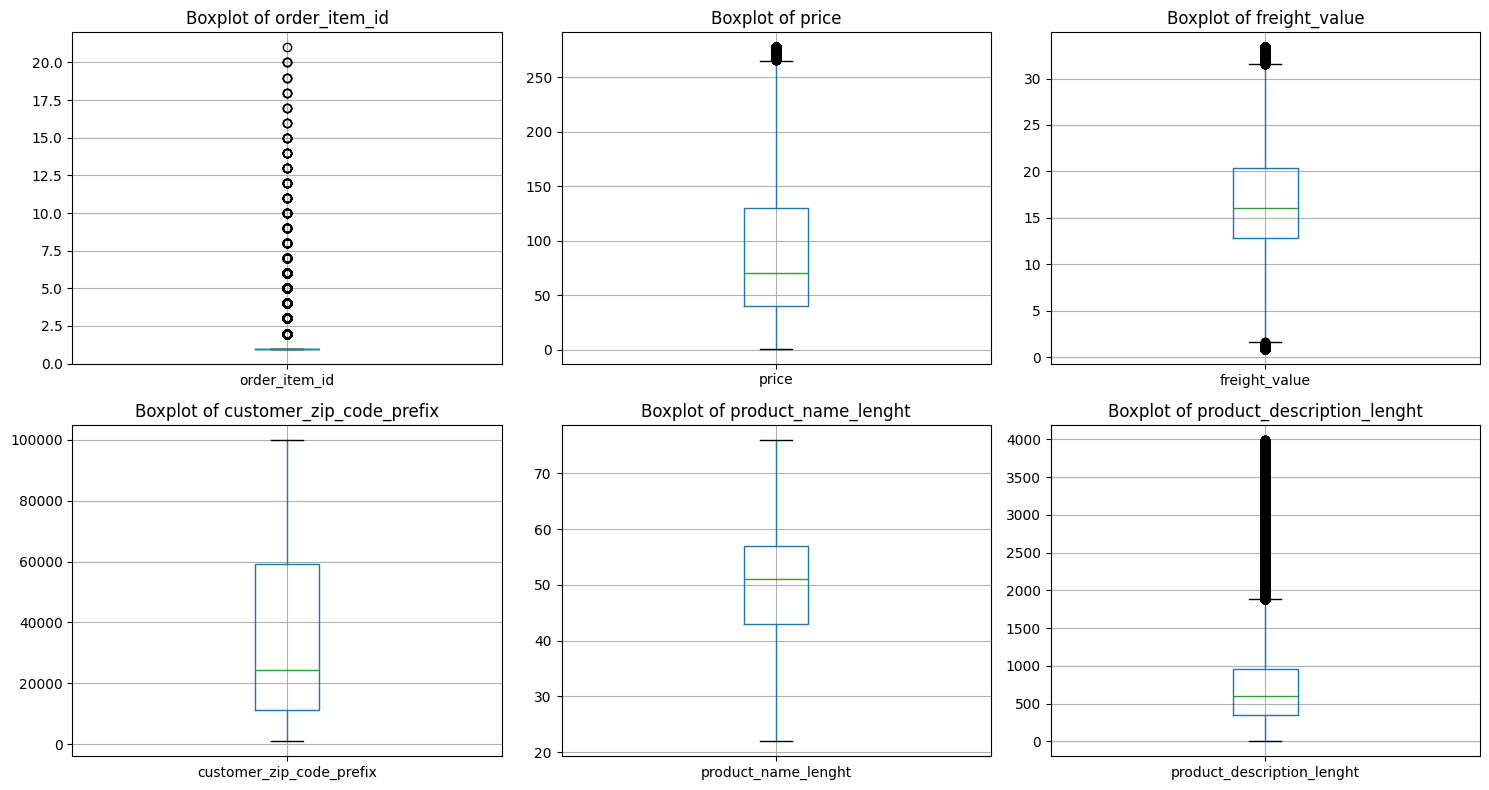

Data cleaning completed successfully!


In [88]:
# Create boxplots to verify outliers after processing
if len(numeric_columns) > 0:
    plt.figure(figsize=(15, 8))
    for i, col in enumerate(numeric_columns[:6]):  # Show only first 6 columns
        if col in data.columns:
            plt.subplot(2, 3, i+1)
            data.boxplot(column=col)
            plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()

print("Data cleaning completed successfully!")